https://www.frontiersin.org/articles/10.3389/fmats.2021.673574/full

In [1]:
from pyiron import Project

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pr = Project('vac')

In [4]:
supercell = pr.create.structure.bulk('Cu', cubic=True).repeat(5)

In [5]:
elements = ['Fe', 'Ni', 'Cr', 'Co', 'Cu']

In [6]:
N = len(supercell)
n = int( len(supercell) / len(elements) )
N, n

(500, 100)

In [7]:
import random

In [8]:
all_elements = elements * 200
random.shuffle(all_elements)
len(all_elements)

1000

In [9]:
for i, e in enumerate(all_elements[:len(supercell)]):
    supercell[i] = e

In [10]:
supercell.get_chemical_formula()

'Co103Cr105Cu103Fe102Ni87'

In [11]:
supercell.plot3d()

NGLWidget()

In [79]:
j = pr.create.job.Lammps("minimize", delete_existing_job=True)

In [79]:
j.structure = supercell
j.potential = j.list_potentials()[0]
j.calc_minimize(pressure=0)

In [80]:
j.run()

The job minimize was saved and received the ID: 15279204


/u/zora/software/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/u/zora/software/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/u/zora/software/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/u/zora/software/pyiron_atomistics/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalize

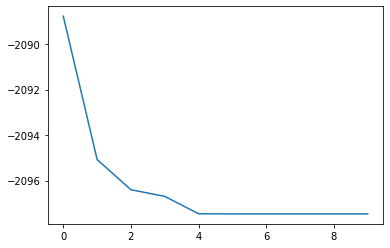

In [81]:
plt.plot(j.output.energy_pot)

In [82]:
j.get_structure().plot3d()

NGLWidget()

In [12]:
supercell_minimized = pr.load('minimize').get_structure(-1)

In [13]:
E0 = pr.load('minimize').output.energy_pot[-1]

In [14]:
E0

-2097.46231807825

In [15]:
j = pr.create.job.Lammps("vacancy", delete_existing_job=True)
j.structure = supercell_minimized
j.potential = j.list_potentials()[0]
j.calc_minimize()

In [16]:
from tqdm import tqdm

In [17]:
j.interactive_open()
N = len(supercell_minimized)
j.interactive_enforce_structure_reset=True
for i in tqdm(range(N)):
    j.structure = supercell_minimized.copy()
    del j.structure[i]
    j.run()
j.interactive_close()

  0%|          | 0/500 [00:00<?, ?it/s]

The job vacancy was saved and received the ID: 15361383


100%|██████████| 500/500 [04:40<00:00,  1.78it/s]


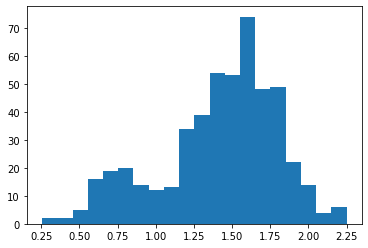

In [19]:
plt.hist(j.output.energy_pot - (N-1)*E0/N, bins=20);

In [22]:
j = pr.load('vacancy')

In [23]:
j.animate_structure()

NGLWidget(max_frame=499)

In [24]:
E_vac_all = j.output.energy_pot

In [25]:
E_vac_avg = E_vac_all.mean() - (N-1)/N * E0

In [26]:
E_vac_avg

1.4177037810190996

In [27]:
E0/N, E_vac_avg/2

(-4.1949246361565, 0.7088518905095498)

$ \mu_X = E_0 + \left< E \right>^f_v - \frac{1}{N_X}\sum_{j=1}^{N_X} E^X_j $

In [37]:
mu = np.array( [
    E0 + E_vac_avg - E_vac_all[supercell.indices == i].mean() for i in np.unique(supercell_minimized.indices)
] )

In [38]:
mu

array([-4.15934841, -4.20135948, -4.19260397, -4.23072897, -4.19162351])

In [39]:
mu.mean()

-4.195132867280063

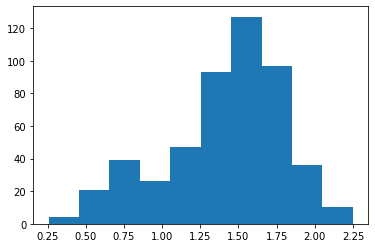

In [40]:
plt.hist(E_vac_all - (N-1)/N * E0);

In [42]:
E_vac = E_vac_all - E0 + mu[ supercell_minimized.indices ]

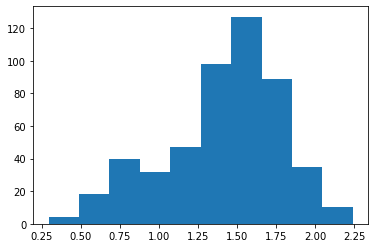

In [43]:
plt.hist(E_vac);

In [46]:
supercell_minimized.species

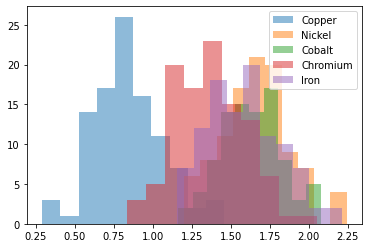

In [47]:
for tpe in np.unique(supercell_minimized.indices):
    plt.hist(E_vac[supercell_minimized.indices == tpe],
             label=supercell_minimized.species[tpe].Name, alpha=.5)
plt.legend()

# Building Descriptors

Neighborhoods of the vacancies are already present in the minimized supercell, and since we're only interested in the types of the neighbors it's easier to analyse the neighborhood in the original structure and actually looking at each of the defected structures.

In [53]:
neigh = supercell_minimized.get_neighbors(num_neighbors=12)

In [59]:
supercell_minimized.get_chemical_symbols()[neigh.indices]

array([['Cr', 'Cr', 'Fe', ..., 'Fe', 'Cu', 'Co'],
       ['Co', 'Cr', 'Co', ..., 'Cr', 'Cu', 'Cu'],
       ['Fe', 'Cr', 'Cu', ..., 'Cu', 'Cu', 'Co'],
       ...,
       ['Ni', 'Cr', 'Fe', ..., 'Cu', 'Cu', 'Cr'],
       ['Co', 'Cr', 'Cu', ..., 'Cu', 'Ni', 'Fe'],
       ['Fe', 'Cr', 'Cr', ..., 'Cu', 'Cr', 'Fe']], dtype='<U2')

Collect the number of neighbors of each type to each vacancy as features.

In [66]:
neighbor_types = supercell_minimized.indices[neigh.indices]

In [87]:
neighbor_counts = ( neighbor_types[:, :, None] == np.unique(supercell_minimized.indices)[None, None, :] ).sum(axis=1)

In [88]:
neighbor_counts.shape

(500, 5)

In [94]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

Use the type of the original atom in the vacancy as an additional feature.  This is a categorical feature, so we start with Tree-based regressors.

In [118]:
features = np.concatenate( [supercell_minimized.indices.reshape(-1, 1), neighbor_counts], axis=-1 )

In [119]:
(features[:, 0] == supercell_minimized.indices).all()

True

In [120]:
features.shape

(500, 6)

## Test Train Split

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
features_train, features_test, E_vac_train, E_vac_test = train_test_split(features, E_vac, test_size=0.33, random_state=42) 

In [217]:
reg = DecisionTreeRegressor()
reg.fit(features_train, E_vac_train)

DecisionTreeRegressor()

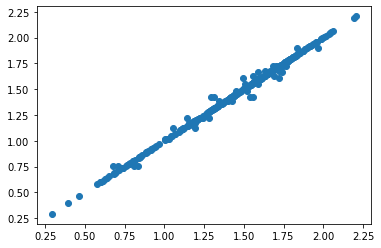

In [218]:
plt.scatter(E_vac_train, reg.predict(features_train))

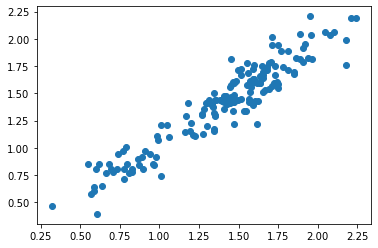

In [219]:
plt.scatter(E_vac_test, reg.predict(features_test))

In [138]:
np.std( E_vac_test - reg.predict(features_test) )

0.19156643495253958

In [139]:
np.std( E_vac_train - reg.predict(features_train) )

0.19968356608526647

Check how deep the tree should be by looking at test vs. train error.

In [221]:
def tree_regressor(max_depth):
    reg = DecisionTreeRegressor(max_depth=max_depth)
    reg.fit(features_train, E_vac_train)
    return np.std( E_vac_test - reg.predict(features_test) ), np.std( E_vac_train - reg.predict(features_train) )

In [222]:
depths = [2,3,4,5,6,7,8,9]
errors = np.array([ tree_regressor(i) for i in depths ])

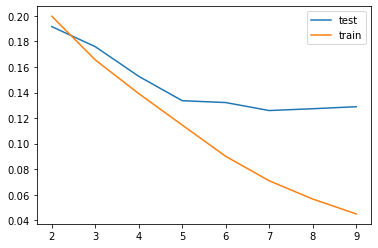

In [224]:
plt.plot(depths, errors[:, 0], label='test')
plt.plot(depths, errors[:, 1], label='train')
plt.legend()

In [225]:
from sklearn.ensemble import RandomForestRegressor # Instantiate model with 1000 decision trees 
rf = RandomForestRegressor(n_estimators = 100, random_state = 42) # Train the model on training data 
rf.fit(features_train, E_vac_train); 

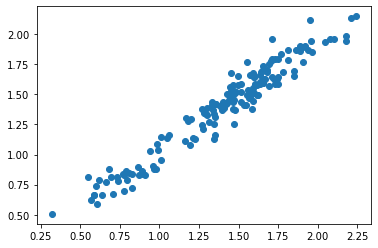

In [226]:
plt.scatter(E_vac_test, rf.predict(features_test))

# Continous Regressors

It's a bit unphysical to use the "discontinous" model of the tree models for something that we'd intuitively write down as something like

$$
e = e_{0,t} + \sum_i \Delta e_{t_i}
$$

where $e_{0,t}$ is the "bare" vacancy energy after an atom of type $t$ has been removed, $\Delta e_{t_i}$ is the energy contribution of a nearest neighbor of type $t_i$ and the sum runs over all first nearest neighbors.

Use the same features as before, though we expect the first feature will make problems to a linear model, that works to be the following model

$$
e = c_\mathrm{type} t + \sum_k c_k n_k
$$

where $c_\mathrm{type}$ and $c_k$ are the regression coefficients, $n_k$ is the number of neighbors of type $k$ and the sum has been rewritten to go over all types of neighbors instead.

In [163]:
from sklearn.linear_model import LinearRegression

In [164]:
reg = LinearRegression()
reg.fit(features_train, E_vac_train)

LinearRegression()

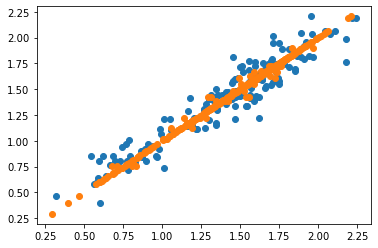

In [228]:
plt.scatter(E_vac_test, reg.predict(features_test))
plt.scatter(E_vac_train, reg.predict(features_train))

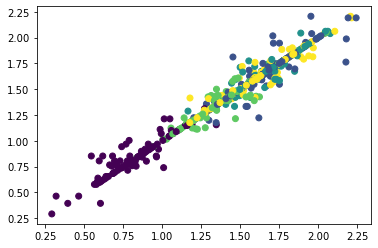

In [229]:
plt.scatter(E_vac_test, reg.predict(features_test), c=supercell_minimized.indices[np.where(E_vac_t)

As expected this model clearly has problems (e.g. getting the cupper vacancies right, cf. the histograms of vacancy energies per type above).

Let's remap the first feature as indices instead of a categorical feature, i.e. instead of one feature $t$ with five possible values, define five features $I_k = \delta_{k, t}$ that are either $0$ or $1$.

In [230]:
type_features = 1.0 * (supercell_minimized.indices[:, None] == np.unique(supercell_minimized.indices)[None, :])
type_features.shape

(500, 5)

In [231]:
type_features

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

The linear model will then be something like

$$
e = \sum_k I_k e_{0, k} + \sum_k n_k \Delta e_k
$$

where the first sum runs over the types of the atom that has been removed and the second  runs over the possible types of neighbors.  $e_{0,k}$ and $\Delta e_k$ are then our regression coefficients exactly as in our first intuition.

In [232]:
features = np.concatenate( [type_features, neighbor_counts], axis=-1 )

In [233]:
features.shape

(500, 10)

## Test Train Split

In [234]:
from sklearn.model_selection import train_test_split

In [235]:
features_train, features_test, E_vac_train, E_vac_test = train_test_split(features, E_vac, test_size=0.33, random_state=42) 

In [119]:
(features[:, 0] == supercell_minimized.indices).all()

True

True

In [199]:
reg = LinearRegression()
reg.fit_intercept=False
reg.fit(features_train, E_vac_train)

LinearRegression(fit_intercept=False)

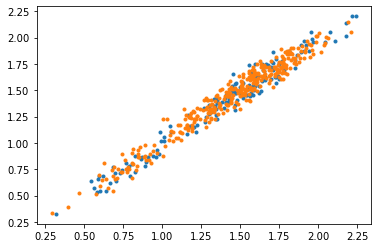

In [216]:
plt.scatter(E_vac_test, reg.predict(features_test), marker='.')
plt.scatter(E_vac_train, reg.predict(features_train), marker='.')

# Great Success!

This is much better than in the orignal paper with a simpler model.  Caveat here is that they also compared predictions where the bulk concentration is different from the training test, whereas we have the same bulk concentration in testing and training.

In [201]:
import scipy.stats as sa

In [181]:
sa.pearsonr(E_vac_test, reg.predict(features_test))

(0.9834839382237308, 6.3407627923203e-123)

In [182]:
np.std(E_vac_test - reg.predict(features_test))

0.07286506616419869

The regression coefficients directly correspond to $e_{0, k}$ \& $\Delta e_k$ as above.

In [202]:
reg.coef_

array([-0.62072486,  0.25808961,  0.22780208, -0.02100866,  0.2046655 ,
        0.03949712,  0.12681157,  0.13123581,  0.06915454,  0.21918484])